# Black-Box Room Modelling
You have a dataset collected from a room, which includes (i) indoor air temperature (Ti) in °C, (ii) outdoor air temperature (To) in °C, (iii) HVAC heating rate (q_HVAC) in W, and (iv) absorbed solar radiation (q_solar) in W. With this dataset, estimate the A and B matrixes.

### Load Libraries & Packages

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.signal import cont2discrete
import pickle
import matplotlib.pyplot as plt
import pygad

### Import and visualize Data

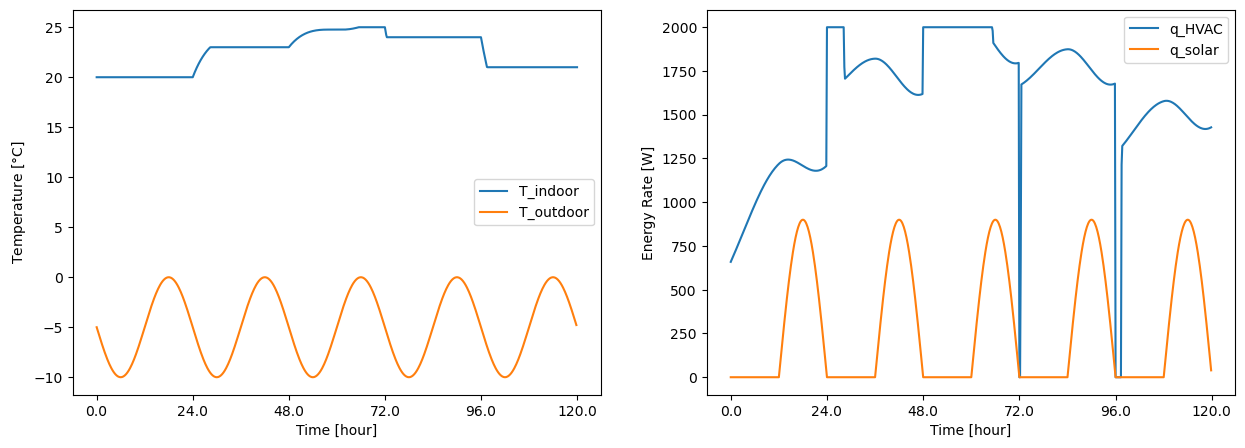

In [2]:
with open('HW1_Data.pickle', 'rb') as f:
    Data = pickle.load(f)
Ti = Data['Ti'] # indoor air temperature in degC
To = Data['To'] # outdoor air temperature in degC
q_HVAC = Data['q_HVAC'] # HVAC heating rate in W
q_solar = Data['q_solar'] # absorbed solar radiation in W
N = To.shape[0] # number of timesteps

t_span = np.arange(0,N+1)
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(Ti, label='T_indoor')
ax[0].plot(To, label='T_outdoor')
ax[0].set_xticks(t_span[::6*24],t_span[::6*24]*10/60)
ax[0].set_ylabel('Temperature [$\degree$C]')
ax[0].set_xlabel('Time [hour]')
ax[0].legend()

ax[1].plot(q_HVAC, label='q_HVAC')
ax[1].plot(q_solar, label='q_solar')
ax[1].set_xticks(t_span[::6*24],t_span[::6*24]*10/60)
ax[1].set_ylabel('Energy Rate [W]')
ax[1].set_xlabel('Time [hour]')
ax[1].legend()

plt.show()

In [3]:
def simulation(params):
    # continuous time invariant state-space
    A = np.array([[params[0],params[1]],
                  [params[2],params[3]]])
    B = np.array([[params[4],params[5],params[6]],
                  [params[7],params[8],params[9]]])
    C = np.eye(2) # assume that C is known
    D = np.zeros((2,3)) # assume that D is known
      
    # discrete state-space
    Ad, Bd, Cd, Dd, _ = cont2discrete((A,B,C,D), 10*60) # discretization with 10 minute time interval
    
    x = np.zeros((2, N+1))
    x[0,0] = 20 # initial Ti
    x[1,0] = 15 # initial Tw
    
    # compute states over the simulation period
    for i in range(N):
        q_HVAC_t = q_HVAC[i]
        q_solar_t = q_solar[i]
        To_t = To[i]
        u_t = np.array([q_HVAC_t, q_solar_t, To_t])[:,None] # input vector
        x[:,i+1:i+2] = np.dot(Ad,x[:,i:i+1]) + np.dot(Bd,u_t)
    return x

def objective(ga_instance, solution, solution_idx):
    # run simulation
    x = simulation(solution)
    
    # error metric
    metric = (np.sqrt(np.mean((Ti - x[0,:])**2)))
    return 1/metric

Generation = 1
Fitness    = 2.1258459896863022
Change     = 2.1258459896863022
Generation = 2
Fitness    = 2.7513848853740175
Change     = 0.6255388956877153
Generation = 3
Fitness    = 2.824985538991837
Change     = 0.07360065361781931
Generation = 4
Fitness    = 2.824985538991837
Change     = 0.0
Generation = 5
Fitness    = 2.8383921216385577
Change     = 0.0134065826467209
Generation = 6
Fitness    = 3.1189560716660134
Change     = 0.2805639500274557
Generation = 7
Fitness    = 3.1189560716660134
Change     = 0.0
Generation = 8
Fitness    = 3.1189560716660134
Change     = 0.0
Generation = 9
Fitness    = 3.1189560716660134
Change     = 0.0
Generation = 10
Fitness    = 3.1189560716660134
Change     = 0.0
Generation = 11
Fitness    = 3.1189560716660134
Change     = 0.0
Generation = 12
Fitness    = 3.1189560716660134
Change     = 0.0
Generation = 13
Fitness    = 3.1189560716660134
Change     = 0.0
Generation = 14
Fitness    = 3.135599910478352
Change     = 0.01664383881233844
Generation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Generation = 100
Fitness    = 3.304975613184754
Change     = 0.02034474566432687


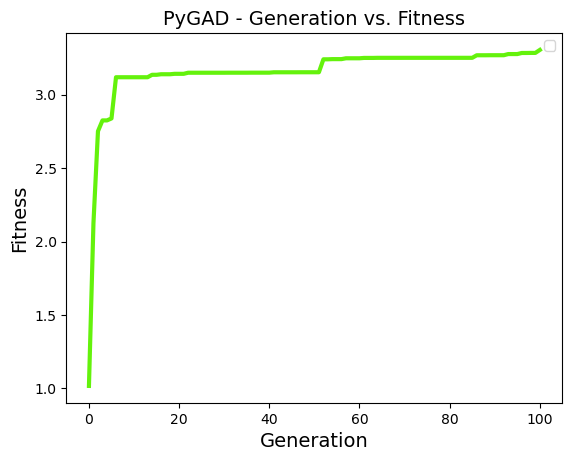

In [7]:
# parameter estimation with a genetic algorithm
last_fitness = 0
def on_generation(ga_instance):
    global last_fitness
    print(f"Generation = {ga_instance.generations_completed}")
    print(f"Fitness    = {ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]}")
    print(f"Change     = {ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1] - last_fitness}")
    last_fitness = ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]

ga_instance = pygad.GA(num_generations=1000,
                       num_parents_mating=10,
                       sol_per_pop=50,
                       gene_space=[{'low': -6.189681377001884e-05, 'high': -4.189681377001884e-05},
                                   {'low': 4.189681377001884e-05, 'high': 6.189681377001884e-05},
                                   {'low': 6.267550052850002e-06, 'high': 8.267550052850002e-06},
                                   {'low': -2.3841170545464912e-05, 'high': -0.3841170545464912e-05},
                                   {'low': 2.790291900513395e-07, 'high': 4.790291900513395e-07},
                                   {'low': -1e-07, 'high': 1e-07},
                                   {'low': -1e-07, 'high': 1e-07},
                                   {'low': -1e-07, 'high': 1e-07},
                                   {'low': 2.560889180559162e-08, 'high': 4.560889180559162e-08},
                                   {'low': 5.573620492614912e-06, 'high': 7.573620492614912e-06}],
                       num_genes=10,
                       fitness_func=objective,
                       on_generation=on_generation
                      )
ga_instance.run()
ga_instance.plot_fitness()
solution, solution_fitness, solution_idx = ga_instance.best_solution(ga_instance.last_generation_fitness)

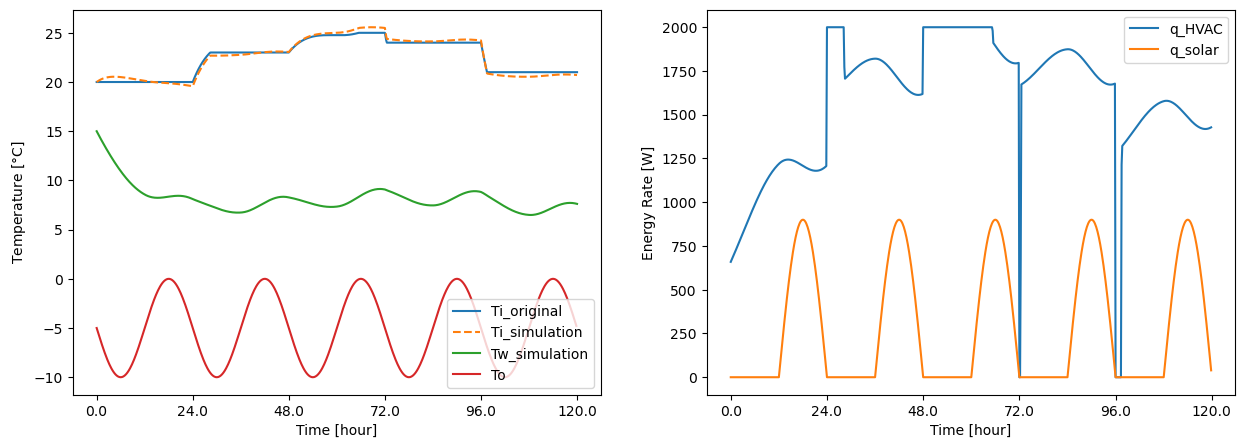

In [8]:
# scale them back
x = simulation(solution)

Ti_simulation = x[0,:] # Indoor temperature 
Tw_simulation = x[1,:]

# plotting
t_span = np.arange(0,N+1)
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(Ti, label='Ti_original')
ax[0].plot(Ti_simulation, label='Ti_simulation', linestyle='--')
ax[0].plot(Tw_simulation, label='Tw_simulation')
ax[0].plot(To, label='To')
ax[0].set_xticks(t_span[::6*24],t_span[::6*24]*10/60)
ax[0].set_ylabel('Temperature [$\degree$C]')
ax[0].set_xlabel('Time [hour]')
ax[0].legend()

ax[1].plot(q_HVAC, label='q_HVAC')
ax[1].plot(q_solar, label='q_solar')
ax[1].set_xticks(t_span[::6*24],t_span[::6*24]*10/60)
ax[1].set_ylabel('Energy Rate [W]')
ax[1].set_xlabel('Time [hour]')
ax[1].legend()

plt.show()